<html>
<table width="100%" cellspacing="2" cellpadding="2" border="1">
<tbody>
<tr>
<td valign="center" align="center" width="45%"><img src="../media/Univ-Utah.jpeg"><br>
</td>
    <td valign="center" align="center" width="75%">
<h1 align="center"><font size="+1">University of Utah<br>Population Health Sciences<br>Data Science Workshop</font></h1></td>
<td valign="center" align="center" width="45%"><img
src="../media/U_Health_stacked_png_red.png" alt="Utah Health
Logo" width="128" height="134"><br>
</td>
</tr>
</tbody>
</table>
<br>
</html>


# Module 3 Exercises
These exercises will ask you to query and analyze data from MIMIC.

In [1]:
from helpers import *

In [2]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

In [49]:
conn = connect_to_mimic()

Enter password for MIMIC2 database········


## 1. Race/ethnicity
### 
Write a query to count how many patients are in each racial/ethnic group. Sort your query results in **ascending alphabetical order** and assign to `ethnicity`. Then create a visualization to display the counts which arranges the plot in **descending order by count**. 

In [51]:
# Option 1: SQL
query = """
SELECT 
    ethnicity_descr,
    COUNT(1) AS num_patients
FROM demographic_detail 
GROUP BY ethnicity_descr
ORDER BY ethnicity_descr desc;
"""
ethnicity = pd.read_sql(query, conn)
ethnicity

,ethnicity_descr,num_patients
0,WHITE - RUSSIAN,1
1,WHITE,3544
2,UNKNOWN/NOT SPECIFIED,730
3,UNABLE TO OBTAIN,18
4,PATIENT DECLINED TO ANSWER,52
5,OTHER,78
6,NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND,2
7,MULTI RACE ETHNICITY,2
8,HISPANIC/LATINO - PUERTO RICAN,3
9,HISPANIC OR LATINO,71


<AxesSubplot:xlabel='num_patients', ylabel='ethnicity_descr'>

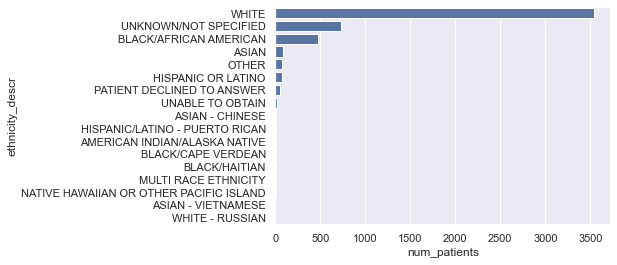

In [52]:
sns.barplot(y="ethnicity_descr", x="num_patients", data=ethnicity.sort_values("num_patients", ascending=False), color="C0")

## 1.2 In-hospital mortality by race
Let's compare the **proportion** of patients who died in the hospital by race. 
1. First, write a query which returns a **patient-level** dataframe (meaning one row per patient) containing the race/ethnicity and whether a patient died in the hospital. 
2. Then group by race/ethnicity (either in pandas or SQL) and calculate the proportion of patients in each category who died in the hospital.
3. Finally, plot the proportions as a barplot.
4. Optionally, filter to groups which have at least 10 patients in them so that the denominator isn't too small.

In [75]:
# RUN CELL TO SEE HINT
hint_mortality_by_race

In [62]:
query = """
SELECT DISTINCT
    p.subject_id,
    d.ethnicity_descr,
    p.hospital_expire_flg
FROM d_patients p
    INNER JOIN demographic_detail d
        ON p.subject_id = d.subject_id
"""
df = pd.read_sql(query, conn)

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [63]:
df["in_hospital_mortality"] = (df["hospital_expire_flg"] == "Y").astype(int)

<AxesSubplot:ylabel='ethnicity_descr'>

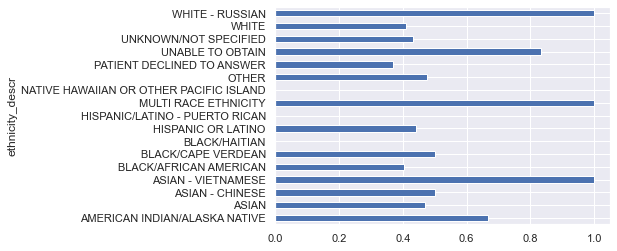

In [71]:
props = df.groupby("ethnicity_descr")["in_hospital_mortality"].mean()
props.plot.barh()

### 1.2 Comparing prevalence by race/ethnicity


In [44]:
query = """
SELECT
	e.ethnicity_descr 
    ,code
    ,n_patients
    ,n_diseased
    ,n_diseased / n_patients prevalence
FROM (
SELECT 
    ethnicity_descr,
    COUNT(1) AS n_patients
FROM demographic_detail 
WHERE ethnicity_descr IN ('BLACK/AFRICAN AMERICAN', 'WHITE')
GROUP BY ethnicity_descr
) e
INNER JOIN (
SELECT d.ethnicity_descr, i.code, COUNT(1) n_diseased
FROM icd9 i
INNER JOIN demographic_detail d
	ON i.hadm_id = d.hadm_id
WHERE code IN ('401.9', '428.0', '427.31', '403.91', '584.9')
GROUP BY ethnicity_descr, i.code
) icd
	ON e.ethnicity_descr = icd.ethnicity_descr
ORDER BY n_diseased / n_patients desc
;
"""
dx_by_race = pd.read_sql(query, conn)

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:xlabel='code', ylabel='prevalence'>

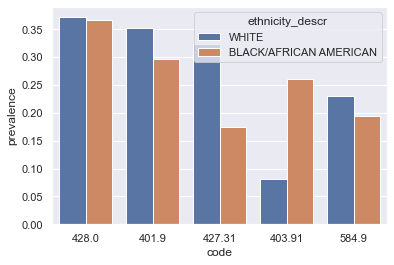

In [47]:
sns.barplot(x="code", y="prevalence", hue="ethnicity_descr", data=dx_by_race)

In [27]:
query = """
SELECT 
	ethnicity_descr,
    COUNT(DISTINCT subject_id) num_patients
FROM demographic_detail d 
INNER JOIN (
	SELECT hadm_id 
    FROM icd9
    WHERE code = '414.01'
) htn
	ON d.hadm_id = htn.hadm_id
WHERE ethnicity_descr IN ('ASIAN',
 'BLACK/AFRICAN AMERICAN',
 'HISPANIC OR LATINO',
 'WHITE')
GROUP BY ethnicity_descr
ORDER BY ethnicity_descr
;
"""
htn = pd.read_sql(query, conn)
htn

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ethnicity_descr,num_patients
0,ASIAN,6
1,BLACK/AFRICAN AMERICAN,45
2,HISPANIC OR LATINO,6
3,WHITE,579


In [28]:
list(htn["ethnicity_descr"])

['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'WHITE']

In [29]:
htn["prop_patients"] = htn["num_patients"] / ethnicity["num_patients"]

In [30]:
htn

,ethnicity_descr,num_patients,prop_patients
0,ASIAN,6,0.001693
1,BLACK/AFRICAN AMERICAN,45,0.633803
2,HISPANIC OR LATINO,6,0.012658
3,WHITE,579,6.732558
